In [1]:
#pip install pydantic, uvicorn, fastapi
from docarray import Document, DocumentArray

d = Document(uri='https://www.gutenberg.org/files/1342/1342-0.txt').load_uri_to_text()
da = DocumentArray(Document(text=s.strip()) for s in d.text.split('\n') if s.strip())
da.apply(lambda d: d.embed_feature_hashing())

                         Documents Summary                         
                                                                   
  Length                 12153                                     
  Homogenous Documents   True                                      
  Common Attributes      ('id', 'mime_type', 'text', 'embedding')  
                                                                   
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('ndarray',)   12153            False            
  id          ('str',)       12153            False            
  mime_type   ('str',)       1                False            
  text        ('str',)       12062            False

In [2]:
q = (Document(text='she smiled too much')
     .embed_feature_hashing()
     .match(da, metric='jaccard', use_scipy=True))

print(q.matches[:5, ('text', 'scores__jaccard__value')])

[['but she smiled too much.', '_little_, she might have fancied too _much_.', 'She perfectly remembered everything that had passed in', 'tolerably detached tone. While she spoke, an involuntary glance', 'much as she chooses.”'], [0.3333333333333333, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75]]


# Image Test

In [11]:
from docarray import DocumentArray

left_da = DocumentArray.from_files('./left/*.jpg')

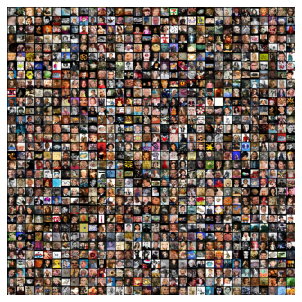

In [12]:
left_da.plot_image_sprites()

In [13]:
from docarray import Document

def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

left_da.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 6016                                  
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       6016             False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   6016             False            
  uri         ('str',)       6016             False

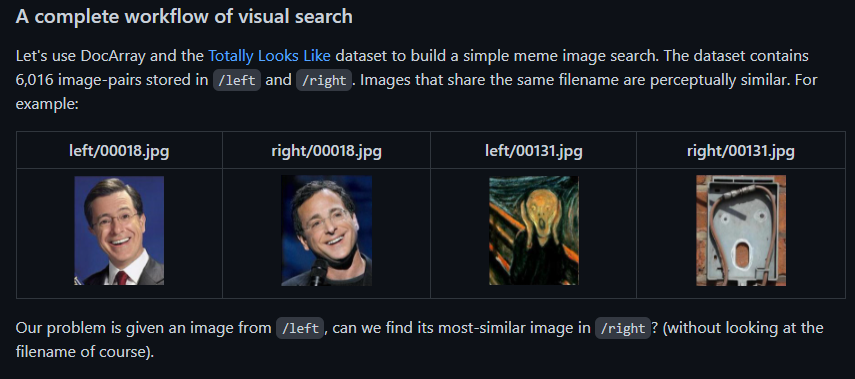

In [15]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50
left_da.embed(model)
#left_da.embed(model, device='cuda')

                             Documents Summary                              
                                                                            
  Length                 6016                                               
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    6016             False            
  id          ('str',)       6016             False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       6016             False            
  uri         ('ndarray',)   6016             False

In [19]:
left_da.plot_embeddings()

/home/fastflair/anaconda3/lib/python3.9/site-packages/docarray/array/mixins/plot.py:264: UserWarning: Showing iframe in cell, you may want to open http://127.0.0.1:51521/static/index.html?config=config.json in a new tab for better experience. Also, `localhost` may need to be changed to the IP address if your jupyter is running remotely. Click "stop" button in the toolbar to move to the next cell.
  warnings.warn(


KeyboardInterrupt: 

In [21]:
right_da = DocumentArray.from_files('./right/*.jpg')

In [23]:
left_da.match(right_da, limit=9)

TypeError: can not determine the array type: ['builtins'].NoneType

In [ ]:
for d in left_da:
    for m in d.matches:
        print(d.uri, m.uri, m.scores['cosine'].value)

In [ ]:
print(left_da['@m', ('uri', 'scores__cosine__value')])

In [ ]:
(DocumentArray(left_da[8].matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())
    .plot_image_sprites())

In [ ]:
groundtruth = DocumentArray(
    Document(uri=d.uri, matches=[Document(uri=d.uri.replace('left', 'right'))]) for d in left_da)

In [ ]:
for k in range(1, 6):
    print(f'recall@{k}',
          left_da.evaluate(
            groundtruth,
            hash_fn=lambda d: d.uri,
            metric='recall_at_k',
            k=k,
            max_rel=1))

If you think a pretrained ResNet50 is good enough, let me tell you with Finetuner you could do much better in just 10 extra lines of code. Here is how: https://finetuner.jina.ai/get-started/totally-looks-like/

In [ ]:
left_da.save('left_da.bin')

In [ ]:
left_da.push(token='my_shared_da')

In [ ]:
left_da = DocumentArray.pull(token='my_shared_da')